In [2]:
import pandas as pd
import itertools
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from lightgbm import LGBMClassifier
import os
import seaborn as sns
from wordcloud import WordCloud

In [3]:
df=pd.read_csv('malicious_phish.csv')

print(df.shape)
df.head()

(651191, 2)


,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [4]:
df.type.value_counts()

type
benign        428103
defacement     96457
phishing       94111
malware        32520
Name: count, dtype: int64

## Plotting Wordcloud

In [4]:
df_phish = df[df.type=='phishing']
df_malware = df[df.type=='malware']
df_deface = df[df.type=='defacement']
df_benign = df[df.type=='benign']


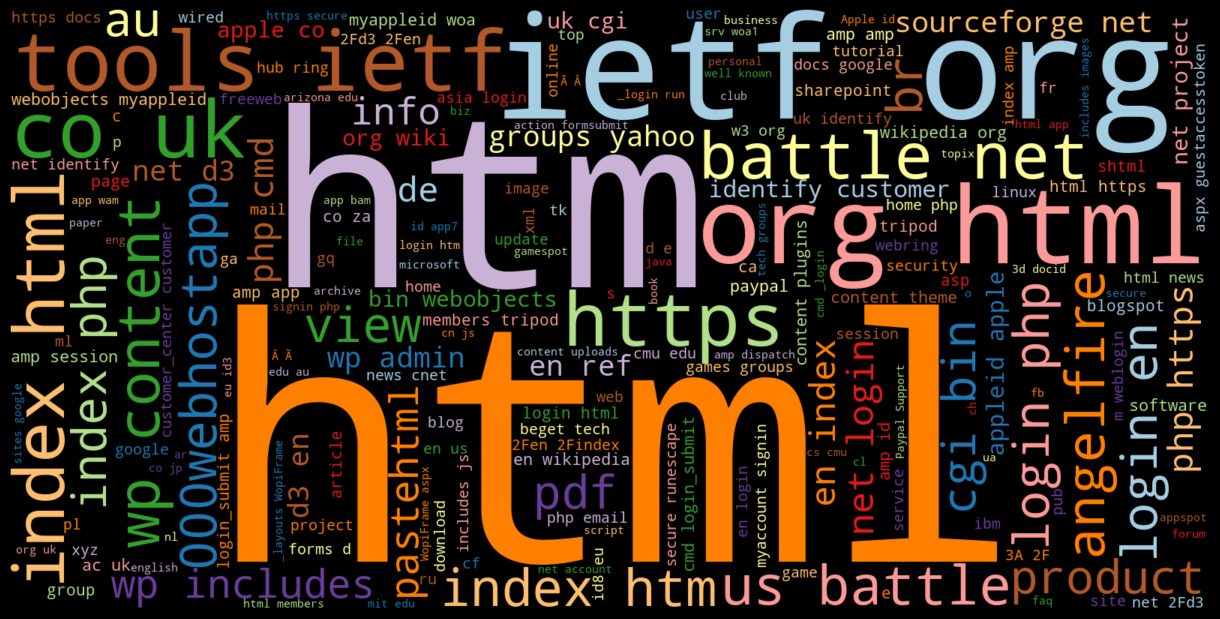

In [6]:
phish_url = " ".join(i for i in df_phish.url)
wordcloud = WordCloud(width=1600, height=800,colormap='Paired').generate(phish_url)
plt.figure( figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

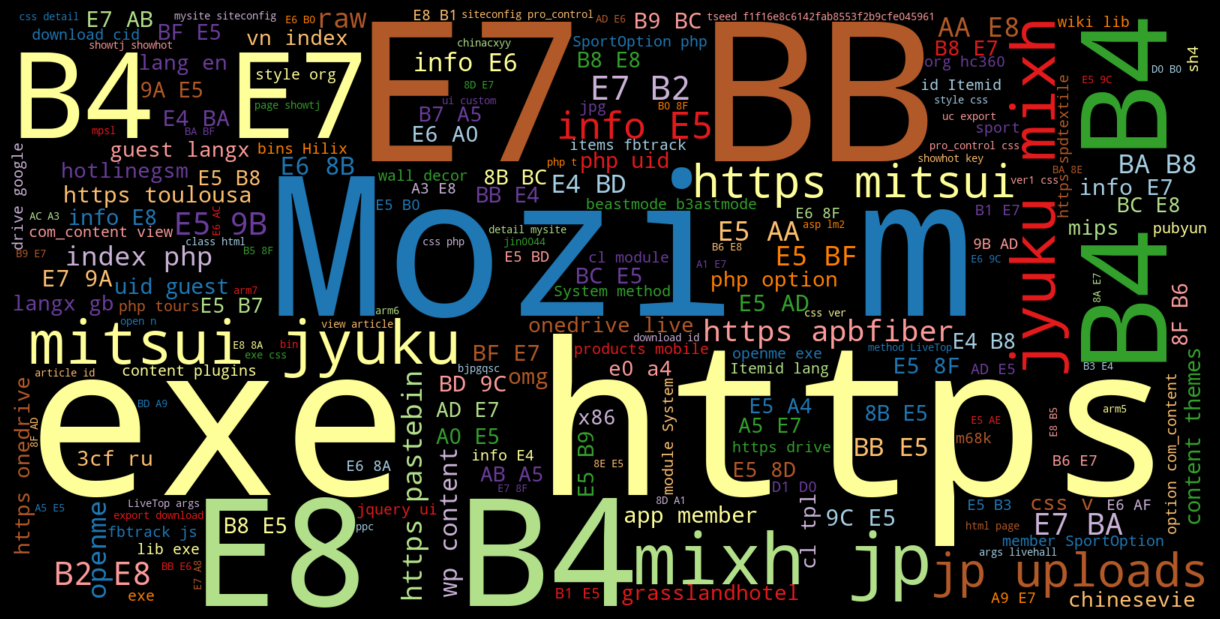

In [5]:
malware_url = " ".join(i for i in df_malware.url)
wordcloud = WordCloud(width=1600, height=800,colormap='Paired').generate(malware_url)
plt.figure( figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

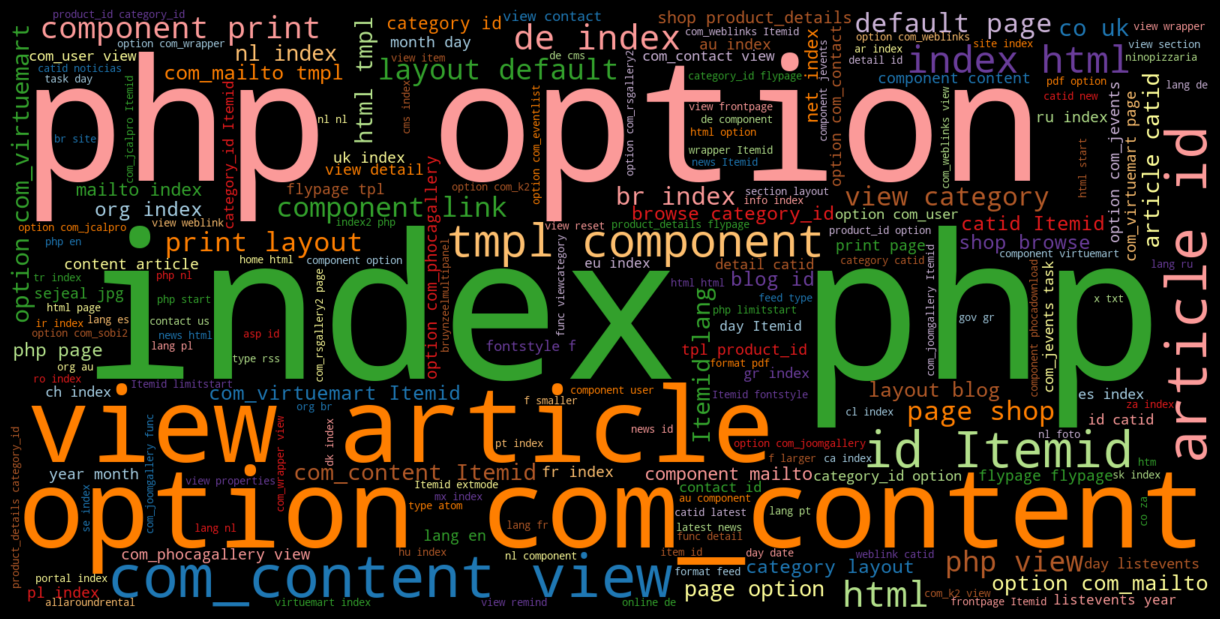

In [8]:
deface_url = " ".join(i for i in df_deface.url)
wordcloud = WordCloud(width=1600, height=800,colormap='Paired').generate(deface_url)
plt.figure( figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

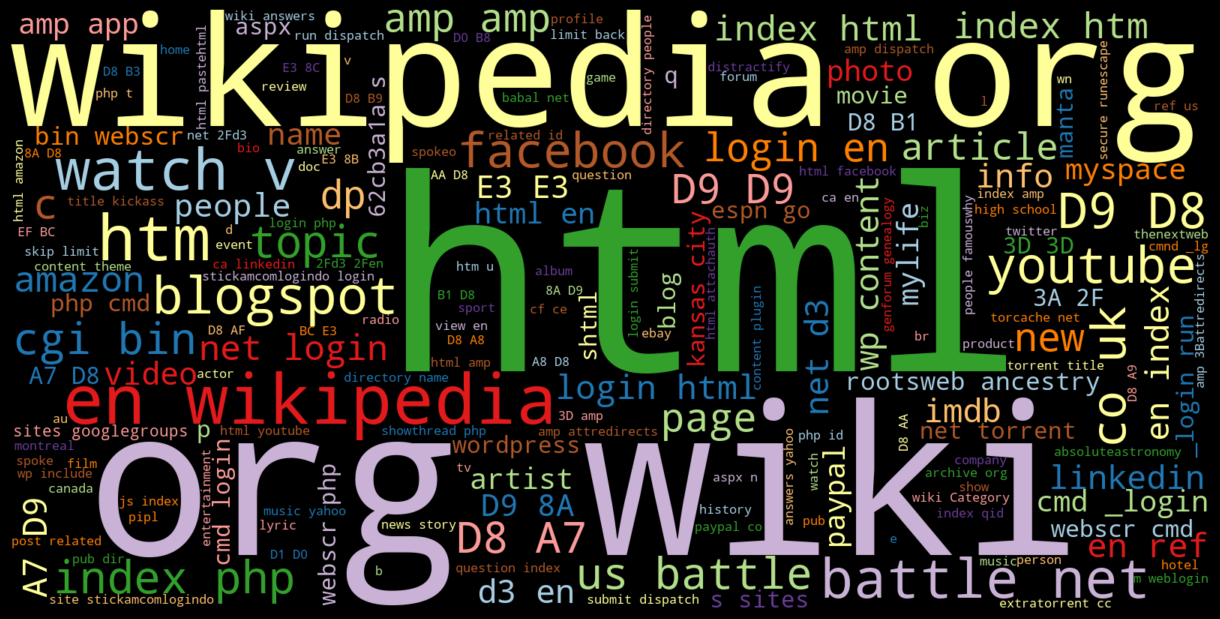

In [6]:
benign_url = " ".join(i for i in df_benign.url)
wordcloud = WordCloud(width=1600, height=800,colormap='Paired').generate(benign_url)
plt.figure( figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

## Feature Engineering

In [7]:
import re
#Use of IP or not in domain
def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}', url)  # Ipv6
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0
df['use_of_ip'] = df['url'].apply(lambda i: having_ip_address(i))

In [8]:
from urllib.parse import urlparse

def abnormal_url(url):
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0


df['abnormal_url'] = df['url'].apply(lambda i: abnormal_url(i))

In [6]:
#!pip install googlesearch-python

In [9]:
from googlesearch import search

In [10]:
def google_index(url):
    site = search(url, 8)
    return 1 if site else 0
df['google_index'] = df['url'].apply(lambda i: google_index(i))

In [11]:
def count_dot(url):
    count_dot = url.count('.')
    return count_dot

df['count.'] = df['url'].apply(lambda i: count_dot(i))
df.head()

,url,type,use_of_ip,abnormal_url,google_index,count.
0,br-icloud.com.br,phishing,0,0,1,2
1,mp3raid.com/music/krizz_kaliko.html,benign,0,0,1,2
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,0,1,2
3,http://www.garage-pirenne.be/index.php?option=...,defacement,0,1,1,3
4,http://adventure-nicaragua.net/index.php?optio...,defacement,0,1,1,2


In [12]:
def count_www(url):
    url.count('www')
    return url.count('www')

df['count-www'] = df['url'].apply(lambda i: count_www(i))


def count_atrate(url):
    return url.count('@')

df['count@'] = df['url'].apply(lambda i: count_atrate(i))


def no_of_dir(url):
    urldir = urlparse(url).path
    return urldir.count('/')

df['count_dir'] = df['url'].apply(lambda i: no_of_dir(i))

def no_of_embed(url):
    urldir = urlparse(url).path
    return urldir.count('//')

df['count_embed_domian'] = df['url'].apply(lambda i: no_of_embed(i))


def shortening_service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0
    
    
df['short_url'] = df['url'].apply(lambda i: shortening_service(i))

<>:28: SyntaxWarning: invalid escape sequence '\.'
<>:29: SyntaxWarning: invalid escape sequence '\.'
<>:30: SyntaxWarning: invalid escape sequence '\.'
<>:31: SyntaxWarning: invalid escape sequence '\.'
<>:32: SyntaxWarning: invalid escape sequence '\.'
<>:33: SyntaxWarning: invalid escape sequence '\.'
<>:34: SyntaxWarning: invalid escape sequence '\.'
<>:35: SyntaxWarning: invalid escape sequence '\.'
<>:28: SyntaxWarning: invalid escape sequence '\.'
<>:29: SyntaxWarning: invalid escape sequence '\.'
<>:30: SyntaxWarning: invalid escape sequence '\.'
<>:31: SyntaxWarning: invalid escape sequence '\.'
<>:32: SyntaxWarning: invalid escape sequence '\.'
<>:33: SyntaxWarning: invalid escape sequence '\.'
<>:34: SyntaxWarning: invalid escape sequence '\.'
<>:35: SyntaxWarning: invalid escape sequence '\.'
C:\Users\yash5\AppData\Local\Temp\ipykernel_16728\4233907613.py:28: SyntaxWarning: invalid escape sequence '\.'
  match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t

In [13]:
def count_https(url):
    return url.count('https://')

df['count-https'] = df['url'].apply(lambda i : count_https(i))

def count_http(url):
    return url.count('http')

df['count-http'] = df['url'].apply(lambda i : count_http(i))

In [14]:
def count_per(url):
    return url.count('%')

df['count%'] = df['url'].apply(lambda i : count_per(i))

def count_ques(url):
    return url.count('?')

df['count?'] = df['url'].apply(lambda i: count_ques(i))

def count_hyphen(url):
    return url.count('-')

df['count-'] = df['url'].apply(lambda i: count_hyphen(i))

def count_equal(url):
    return url.count('=')

df['count='] = df['url'].apply(lambda i: count_equal(i))

def url_length(url):
    return len(str(url))


#Length of URL
df['url_length'] = df['url'].apply(lambda i: url_length(i))
#Hostname Length

def hostname_length(url):
    return len(urlparse(url).netloc)

df['hostname_length'] = df['url'].apply(lambda i: hostname_length(i))

df.head()

def suspicious_words(url):
    match = re.search('PayPal|login|signin|bank|account|update|free|lucky|service|bonus|ebayisapi|webscr',
                      url)
    if match:
        return 1
    else:
        return 0
df['sus_url'] = df['url'].apply(lambda i: suspicious_words(i))


def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits


df['count-digits']= df['url'].apply(lambda i: digit_count(i))


def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters


df['count-letters']= df['url'].apply(lambda i: letter_count(i))

df.head()

,url,type,use_of_ip,abnormal_url,google_index,count.,count-www,count@,count_dir,count_embed_domian,...,count-http,count%,count?,count-,count=,url_length,hostname_length,sus_url,count-digits,count-letters
0,br-icloud.com.br,phishing,0,0,1,2,0,0,0,0,...,0,0,0,1,0,16,0,0,0,13
1,mp3raid.com/music/krizz_kaliko.html,benign,0,0,1,2,0,0,2,0,...,0,0,0,0,0,35,0,0,1,29
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,0,1,2,0,0,3,0,...,0,0,0,0,0,31,0,0,1,25
3,http://www.garage-pirenne.be/index.php?option=...,defacement,0,1,1,3,1,0,1,0,...,1,0,1,1,4,88,21,0,7,63
4,http://adventure-nicaragua.net/index.php?optio...,defacement,0,1,1,2,0,0,1,0,...,1,0,1,1,3,235,23,0,22,199


In [15]:
#!pip install tld

In [16]:
#Importing dependencies
from urllib.parse import urlparse
from tld import get_tld
import os.path

#First Directory Length
def fd_length(url):
    urlpath= urlparse(url).path
    try:
        return len(urlpath.split('/')[1])
    except:
        return 0

df['fd_length'] = df['url'].apply(lambda i: fd_length(i))

#Length of Top Level Domain
df['tld'] = df['url'].apply(lambda i: get_tld(i,fail_silently=True))


def tld_length(tld):
    try:
        return len(tld)
    except:
        return -1

df['tld_length'] = df['tld'].apply(lambda i: tld_length(i))

In [17]:
df = df.drop("tld",axis=1)

In [18]:
df.columns

Index(['url', 'type', 'use_of_ip', 'abnormal_url', 'google_index', 'count.',
       'count-www', 'count@', 'count_dir', 'count_embed_domian', 'short_url',
       'count-https', 'count-http', 'count%', 'count?', 'count-', 'count=',
       'url_length', 'hostname_length', 'sus_url', 'count-digits',
       'count-letters', 'fd_length', 'tld_length'],
      dtype='object')

In [19]:
df['type'].value_counts()

type
benign        428103
defacement     96457
phishing       94111
malware        32520
Name: count, dtype: int64

## EDA

## 1. Distribution of use_of_ip

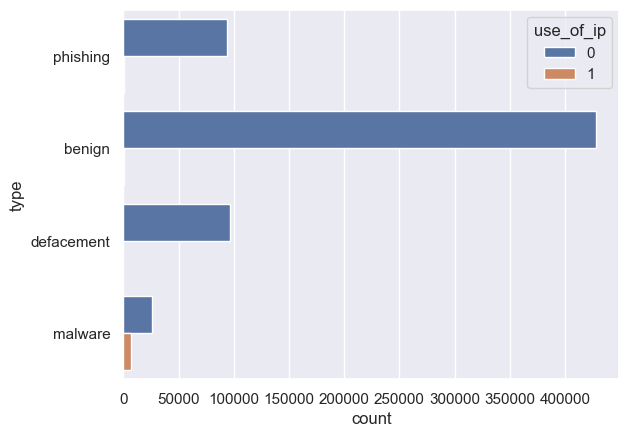

In [20]:
import seaborn as sns
sns.set(style="darkgrid")
ax = sns.countplot(y="type", data=df,hue="use_of_ip")


## 2. Distribution of abnormal url

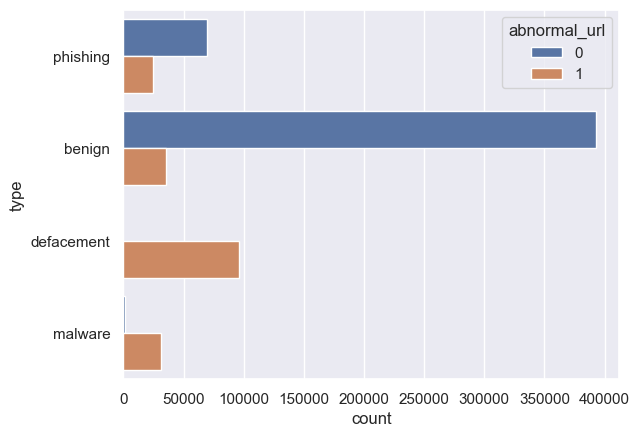

In [21]:
sns.set(style="darkgrid")
ax = sns.countplot(y="type", data=df,hue="abnormal_url")


## 3. Distribution of Google Index

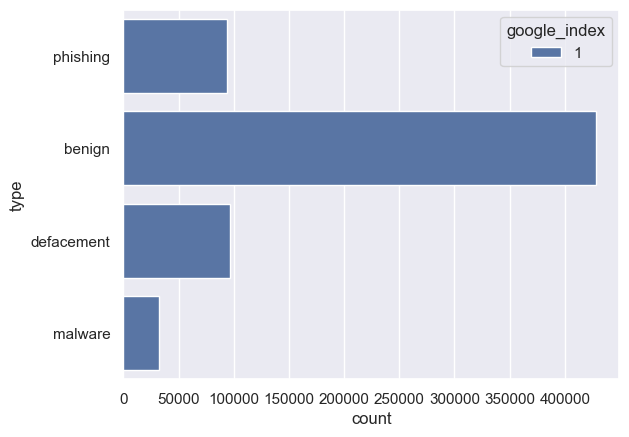

In [22]:
sns.set(style="darkgrid")
ax = sns.countplot(y="type", data=df,hue="google_index")

## 4. Distribution of Shorl URL

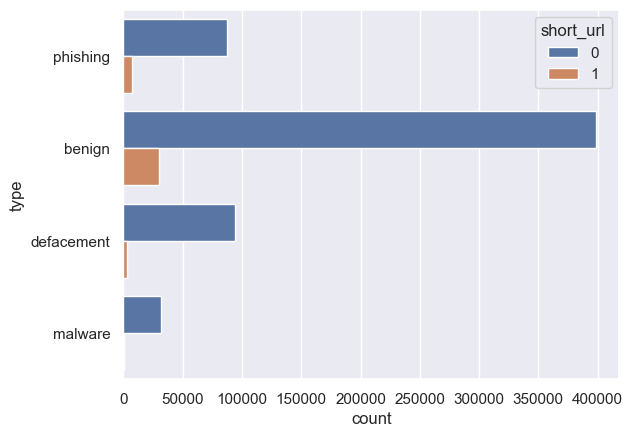

In [23]:
sns.set(style="darkgrid")
ax = sns.countplot(y="type", data=df,hue="short_url")

## 5. Distribution of Suspicious URL

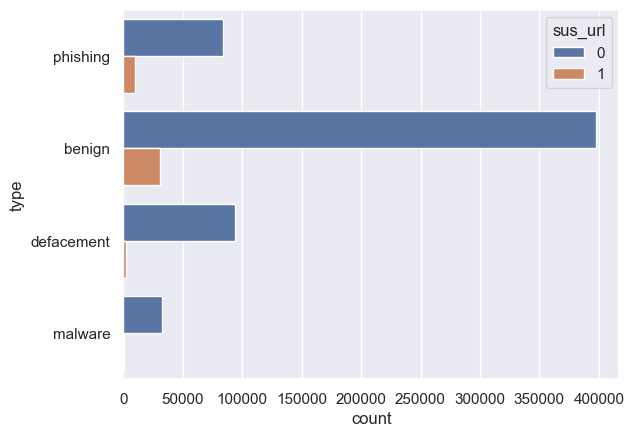

In [24]:
sns.set(style="darkgrid")
ax = sns.countplot(y="type", data=df,hue="sus_url")

## 6. Distribution of count of [.] dot

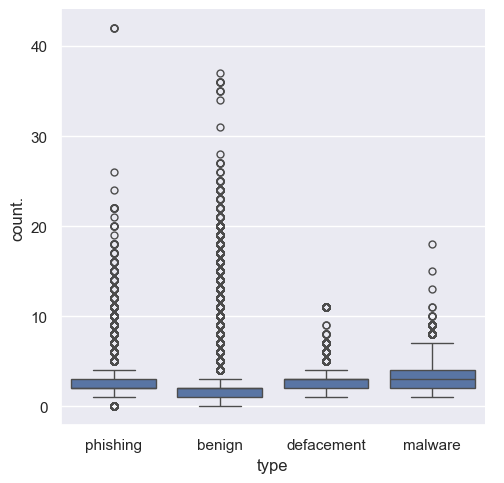

In [25]:
sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="count.", kind="box", data=df)

## 7. Distribution of count-www

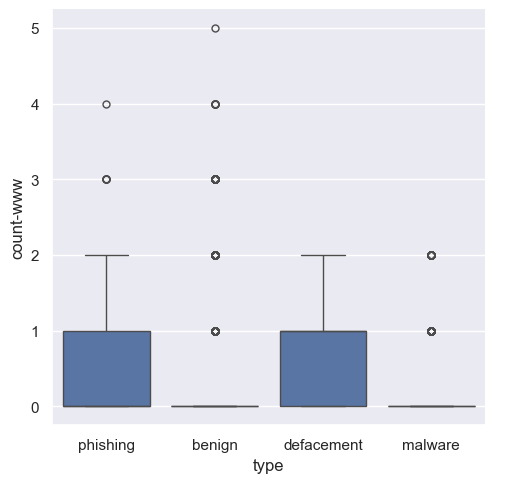

In [26]:
sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="count-www", kind="box", data=df)

## 8. Distribution of count@

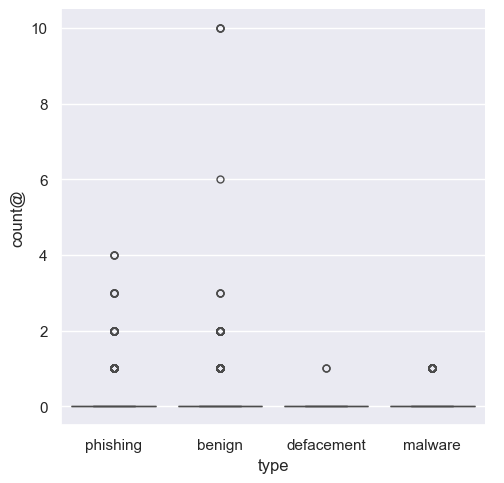

In [27]:
sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="count@", kind="box", data=df)

## 9. Distribution of count_dir

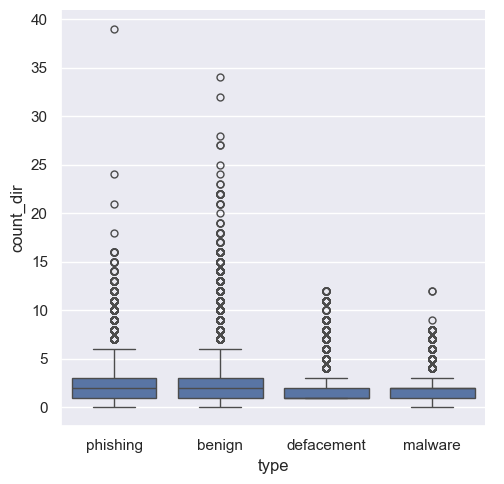

In [28]:
sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="count_dir", kind="box", data=df)

## 10. Distribution of hostname length

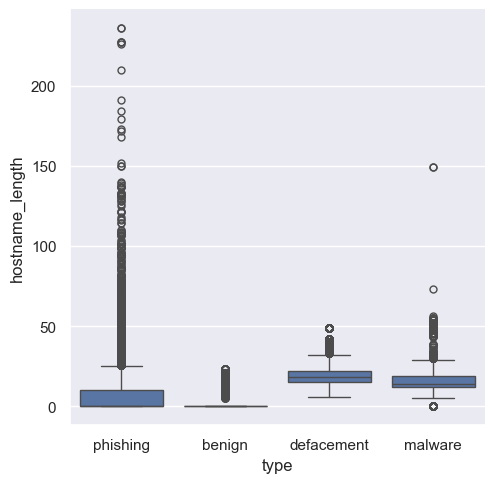

In [29]:
sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="hostname_length", kind="box", data=df)

## 11. Distribution of first directory length

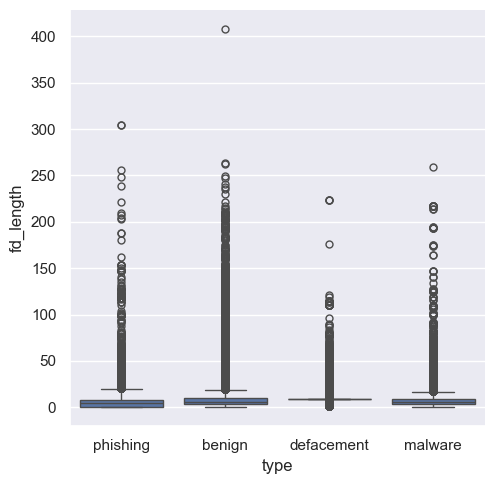

In [30]:
sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="fd_length", kind="box", data=df)

## 12. Distribution of top-level domain length

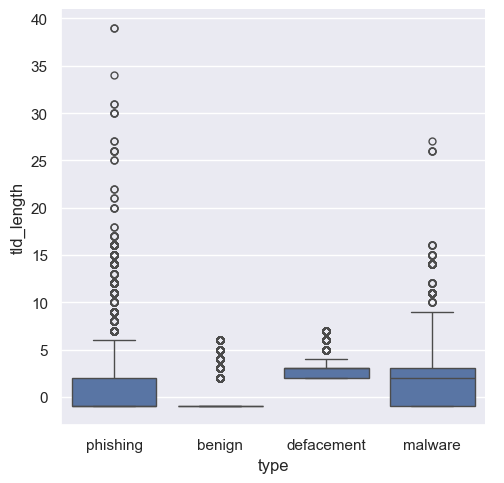

In [31]:
sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="tld_length", kind="box", data=df)

## Target Encoding

In [32]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
df["type_code"] = lb_make.fit_transform(df["type"])
df["type_code"].value_counts()



type_code
0    428103
1     96457
3     94111
2     32520
Name: count, dtype: int64

## Creation of Feature & Target 

In [33]:
#Predictor Variables
# filtering out google_index as it has only 1 value
X = df[['use_of_ip','abnormal_url', 'count.', 'count-www', 'count@',
       'count_dir', 'count_embed_domian', 'short_url', 'count-https',
       'count-http', 'count%', 'count?', 'count-', 'count=', 'url_length',
       'hostname_length', 'sus_url', 'fd_length', 'tld_length', 'count-digits',
       'count-letters']]

#Target Variable
y = df['type_code']


In [34]:
X.head()

,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,short_url,count-https,count-http,...,count?,count-,count=,url_length,hostname_length,sus_url,fd_length,tld_length,count-digits,count-letters
0,0,0,2,0,0,0,0,0,0,0,...,0,1,0,16,0,0,0,-1,0,13
1,0,0,2,0,0,2,0,0,0,0,...,0,0,0,35,0,0,5,-1,1,29
2,0,0,2,0,0,3,0,0,0,0,...,0,0,0,31,0,0,7,-1,1,25
3,0,1,3,1,0,1,0,0,0,1,...,1,1,4,88,21,0,9,2,7,63
4,0,1,2,0,0,1,0,0,0,1,...,1,1,3,235,23,0,9,3,22,199


In [35]:
X.columns

Index(['use_of_ip', 'abnormal_url', 'count.', 'count-www', 'count@',
       'count_dir', 'count_embed_domian', 'short_url', 'count-https',
       'count-http', 'count%', 'count?', 'count-', 'count=', 'url_length',
       'hostname_length', 'sus_url', 'fd_length', 'tld_length', 'count-digits',
       'count-letters'],
      dtype='object')

## Train Test Split

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2,shuffle=True, random_state=5)

# Model Building 

## 1. Random Forest Classifier

In [37]:
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train,y_train)
y_pred_rf = rf.predict(X_test)
print(classification_report(y_test,y_pred_rf,target_names=['benign', 'defacement','phishing','malware']))

score = metrics.accuracy_score(y_test, y_pred_rf)
print("accuracy:   %0.3f" % score)

              precision    recall  f1-score   support

      benign       0.97      0.98      0.98     85621
  defacement       0.98      0.99      0.99     19292
    phishing       0.99      0.94      0.97      6504
     malware       0.91      0.86      0.88     18822

    accuracy                           0.97    130239
   macro avg       0.96      0.95      0.95    130239
weighted avg       0.97      0.97      0.97    130239

accuracy:   0.966


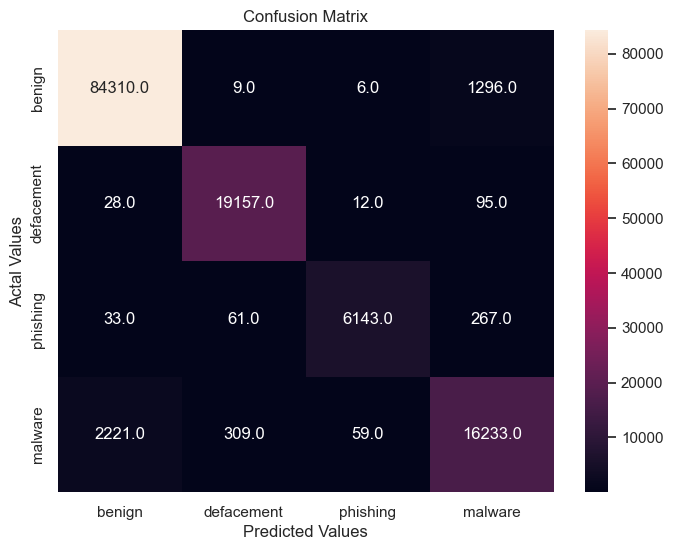

In [38]:
cm = confusion_matrix(y_test, y_pred_rf)
cm_df = pd.DataFrame(cm,
                     index = ['benign', 'defacement','phishing','malware'], 
                     columns = ['benign', 'defacement','phishing','malware'])
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,fmt=".1f")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

<Axes: >

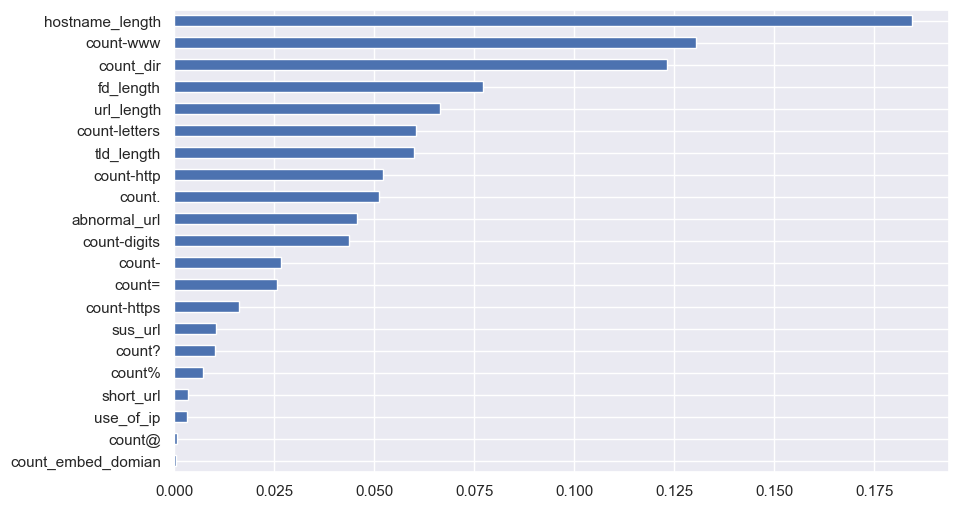

In [39]:
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_importances.sort_values().plot(kind="barh",figsize=(10, 6))

## 2. Light GBM Classifier

In [40]:
from sklearn import metrics


lgb = LGBMClassifier(objective='multiclass',boosting_type= 'gbdt',n_jobs = 5, 
          silent = True, random_state=5)
LGB_C = lgb.fit(X_train, y_train)


y_pred_lgb = LGB_C.predict(X_test)
print(classification_report(y_test,y_pred_lgb,target_names=['benign', 'defacement','phishing','malware']))

score = metrics.accuracy_score(y_test, y_pred_lgb)
print("accuracy:   %0.3f" % score)

[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032052 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1158
[LightGBM] [Info] Number of data points in the train set: 520952, number of used features: 21
[LightGBM] [Info] Start training from score -0.419439
[LightGBM] [Info] Start training from score -1.909712
[LightGBM] [Info] Start training from score -2.996946
[LightGBM] [Info] Start training from score -1.934324
[LightGBM] [Warning] Unknown parameter: silent
              precision    recall  f1-score   support

      benign       0.97      0.99      0.98     85621
  defacement       0.96      0.99      0.98     19292
    phishing       0.97      0.90      0.93      6504
     malware       0.90      0.83      0.86     18822

    accuracy     

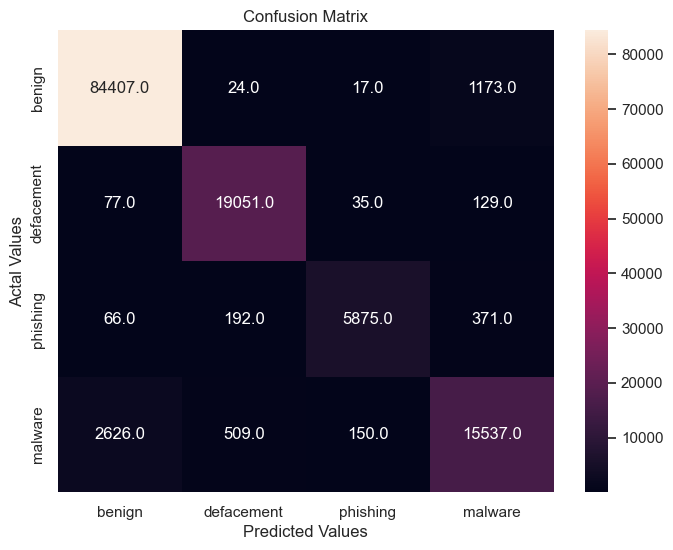

In [41]:
cm = confusion_matrix(y_test, y_pred_lgb)
cm_df = pd.DataFrame(cm,
                     index = ['benign', 'defacement','phishing','malware'], 
                     columns = ['benign', 'defacement','phishing','malware'])
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,fmt=".1f")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()


<Axes: >

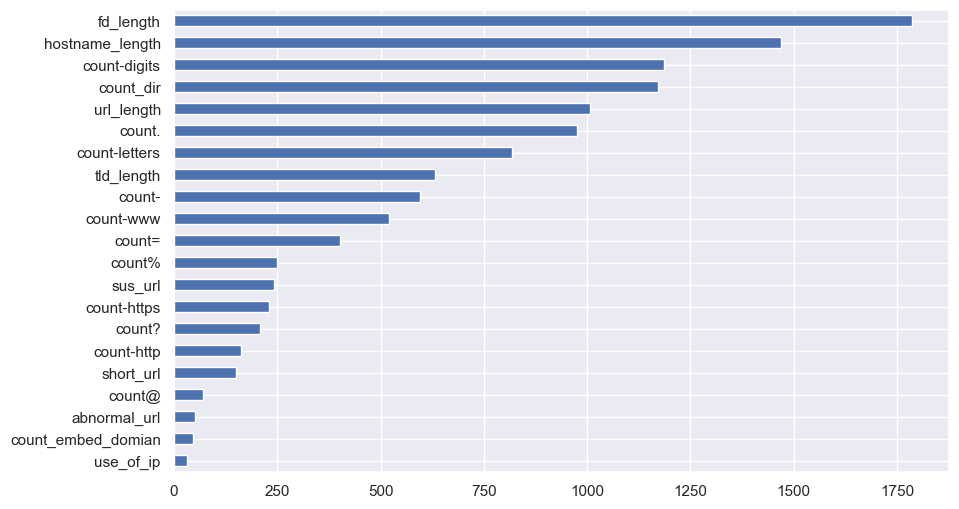

In [42]:
feat_importances = pd.Series(lgb.feature_importances_, index=X_train.columns)
feat_importances.sort_values().plot(kind="barh",figsize=(10, 6))

## 3. XGboost Classifier

In [43]:
from sklearn import metrics


xgb_c = xgb.XGBClassifier(n_estimators= 100)
xgb_c.fit(X_train,y_train)
y_pred_x = xgb_c.predict(X_test)
print(classification_report(y_test,y_pred_x,target_names=['benign', 'defacement','phishing','malware']))


score = metrics.accuracy_score(y_test, y_pred_x)
print("accuracy:   %0.3f" % score)

              precision    recall  f1-score   support

      benign       0.97      0.99      0.98     85621
  defacement       0.97      0.99      0.98     19292
    phishing       0.97      0.91      0.94      6504
     malware       0.91      0.83      0.87     18822

    accuracy                           0.96    130239
   macro avg       0.96      0.93      0.94    130239
weighted avg       0.96      0.96      0.96    130239

accuracy:   0.962


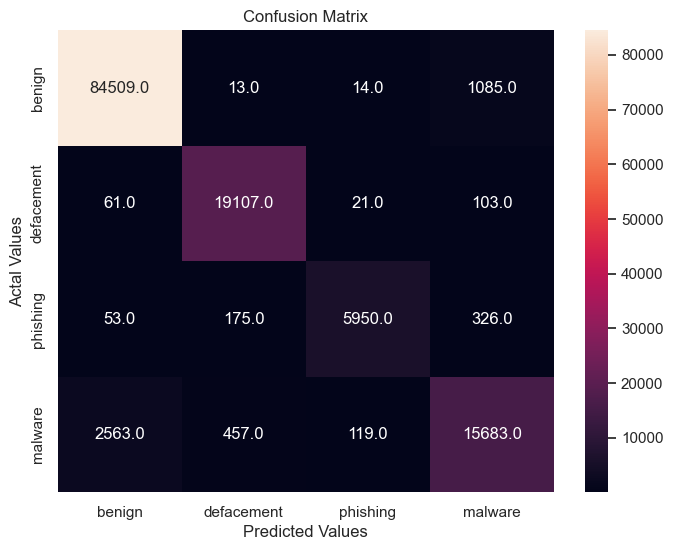

In [44]:
cm = confusion_matrix(y_test, y_pred_x)
cm_df = pd.DataFrame(cm,
                     index = ['benign', 'defacement','phishing','malware'], 
                     columns = ['benign', 'defacement','phishing','malware'])
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,fmt=".1f")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

<Axes: >

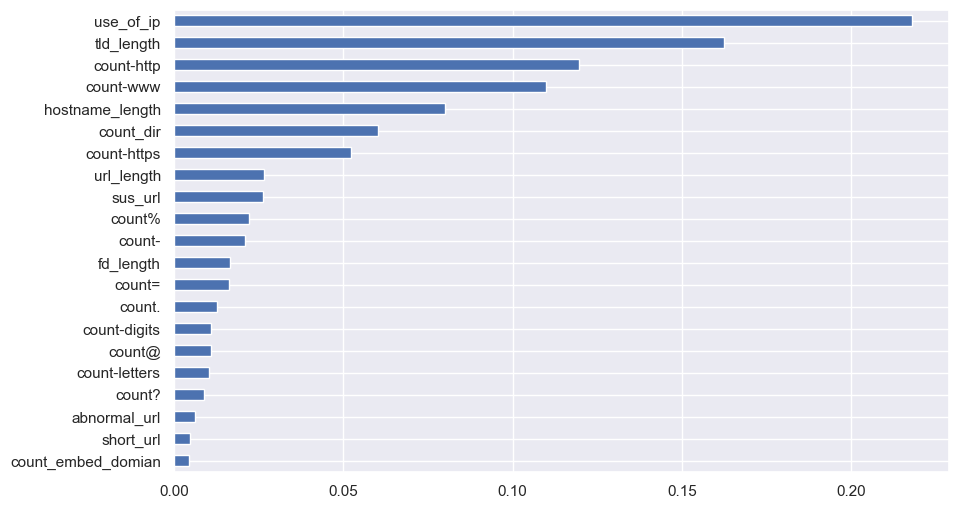

In [45]:
feat_importances = pd.Series(xgb_c.feature_importances_, index=X_train.columns)
feat_importances.sort_values().plot(kind="barh",figsize=(10, 6))

## Prediction

In [46]:
def main(url):
    
    status = []

    status.append(having_ip_address(url))
    status.append(abnormal_url(url))
    status.append(count_dot(url))
    status.append(count_www(url))
    status.append(count_atrate(url))
    status.append(no_of_dir(url))
    status.append(no_of_embed(url))
    
    status.append(shortening_service(url))
    status.append(count_https(url))
    status.append(count_http(url))
    
    status.append(count_per(url))
    status.append(count_ques(url))
    status.append(count_hyphen(url))
    status.append(count_equal(url))
    
    status.append(url_length(url))
    status.append(hostname_length(url))
    status.append(suspicious_words(url))
    status.append(digit_count(url))
    status.append(letter_count(url))
    status.append(fd_length(url))
    tld = get_tld(url,fail_silently=True)
      
    status.append(tld_length(tld))
    
    
    

    return status

In [47]:

def get_prediction_from_url(test_url):
    features_test = main(test_url)
    # Due to updates to scikit-learn, we now need a 2D array as a parameter to the predict function.
    features_test = np.array(features_test).reshape((1, -1))

    

    pred = lgb.predict(features_test)
    if int(pred[0]) == 0:
        
        res="SAFE"
        return res
    elif int(pred[0]) == 1.0:
        
        res="DEFACEMENT"
        return res
    elif int(pred[0]) == 2.0:
        res="PHISHING"
        return res
        
    elif int(pred[0]) == 3.0:
        
        res="NOT SAFE"
        return res
    

In [54]:

# urls = ['titaniumcorporate.co.za','en.wikipedia.org/wiki/North_Dakota']
# for url in urls:
#      print(get_prediction_from_url(url))

urls = 'https//getbootstrap.com/'
print(get_prediction_from_url(urls))


[LightGBM] [Warning] Unknown parameter: silent
SAFE
